# Target

- Solve a classification problem with deep neural networks (DNNs)
    - concat n frames
    - add layers : Implement 2 models with approximately the same number of parameters, (A) one narrower and deeper (e.g. hidden_layers=6, hidden_dim=1024) and (B) the other wider and shallower (e.g. hidden_layers=2, hidden_dim=1750). Report training/validation accuracies for both models.
    - batchnorm, dropout : Add dropout layers, and report training/validation accuracies with dropout rates equal to (A) 0.25/(B) 0.5/(C) 0.75 respectively.

- Solve a classification problem with recursive neural networks (RNNs).




# Library

In [1]:
import random
import os
import argparse
from tqdm import tqdm

import numpy as np

from torch.utils.data import Dataset
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import gc

# Helper function

- `random.seed(seed)`: Sets the seed for **Python's built-in** random module.
- `np.random.seed(seed)`: Sets the seed for **NumPy's** random number generator.
- `torch.manual_seed(seed)`: Sets the seed for **PyTorch on the CPU**.
- `torch.cuda.manual_seed(seed)`: Sets the seed for the **current GPU**.
- `torch.cuda.manual_seed_all(seed)`: Sets the seed for **all GPUs**.
- `torch.backends.cudnn.benchmark = False`: Disables the CuDNN benchmark mode.
- `torch.backends.cudnn.deterministic = True`: Forces CuDNN to use deterministic algorithms, which helps in reproducibility.

`torch.backends.cudnn.benchmark` 是 PyTorch 的一個設置，用來啟用或禁用 CuDNN 的基準模式：

- True：讓 CuDNN 尋找最佳的卷積算法，可能提高訓練速度，但結果可能不可重現。
- False：使用固定的算法，確保結果可重現，通常用於測試和比較實驗結果。

**在追求可重現性時，可設置為 False**

In [2]:
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmarkbe = False
    torch.backends.cudnn.deterministic = True

- 函數：

`load_feat(path)`：

    從指定路徑加載 PyTorch 張量。

`shift(x, n)`：

    將張量 x 向左或向右移動 n 個位置。
    根據移動方向用第一或最後一個元素填充。

`concat_feat(x, concat_n)`：

    在每個幀周圍串聯 concat_n 幀。
    確保 concat_n 是奇數。
    使用 shift 函數來正確調整每個幀。

- 主函數：
`preprocess_data(split, feat_dir, phone_path, concat_nframes, train_ratio=0.8)`：

    用於訓練、驗證或測試的數據預處理。
    加載和串聯特徵。
    根據 train_ratio 將數據拆分為訓練集和驗證集。
    
    - 步驟：

        - 加載數據：

            讀取標籤並拆分數據集。
            使用 load_feat 加載特徵文件。
            特徵串聯：

            使用 concat_feat 串聯幀以提供上下文。
            數據準備：

            為特徵 (X) 和標籤 (y) 準備張量。

        - 輸出：

            返回處理好的訓練/驗證集的特徵和標籤張量，或僅返回測試集的特徵。
            關鍵點：
            concat_nframes 必須是奇數以確保對稱上下文。
            train_ratio 控制訓練和驗證之間的拆分比例。
            預定義的最大長度 (max_len) 保證了內存的高效分配，可以根據需要調整。
            使用 tqdm 來追踪進度。

---

In [3]:
def load_feat(path):
    feat = torch.load(path)
    return feat

def shift(x: torch.Tensor, n: int) -> torch.Tensor:
    if n < 0:
        left = x[0].repeat(-n, 1)
        right = x[:n]
    elif n > 0:
        right = x[-1].repeat(n, 1)
        left = x[n:]
    else:
        return x

    return torch.cat((left, right), dim=0)

def concat_feat(x: torch.Tensor, concat_n: int):
    assert concat_n % 2 == 1 # n must be odd
    if concat_n < 2:
        return x
    seq_len, feature_dim = x.size(0), x.size(1)
    x = x.repeat(1, concat_n)
    x = x.view(seq_len, concat_n, feature_dim).permute(1, 0, 2) # concat_n, seq_len, feature_dim
    mid = (concat_n // 2)
    for r_idx in range(1, mid+1):
        x[mid + r_idx, :] = shift(x[mid + r_idx], r_idx)
        x[mid - r_idx, :] = shift(x[mid - r_idx], -r_idx)

    return x.permute(1, 0, 2).view(seq_len, concat_n * feature_dim)


**Explain**

In [ ]:
test = torch.Tensor([[1,2,3],
                     [4,5,6],
                     [7,8,9],
                     [10,11,12]])

shift(test,2)

tensor([[ 7.,  8.,  9.],
        [10., 11., 12.],
        [10., 11., 12.],
        [10., 11., 12.]])

In [ ]:
test.shape

torch.Size([4, 3])

In [ ]:
test.repeat(1, 3).shape

torch.Size([4, 9])

In [ ]:
seq_len, feature_len = test.size(0), test.size(1) # 4*3
test = test.repeat(1, 3) # 4*9
test.view(seq_len, 3, feature_len) # 4 *3 *3

tensor([[[ 1.,  2.,  3.],
         [ 1.,  2.,  3.],
         [ 1.,  2.,  3.]],

        [[ 4.,  5.,  6.],
         [ 4.,  5.,  6.],
         [ 4.,  5.,  6.]],

        [[ 7.,  8.,  9.],
         [ 7.,  8.,  9.],
         [ 7.,  8.,  9.]],

        [[10., 11., 12.],
         [10., 11., 12.],
         [10., 11., 12.]]])

In [ ]:
test = test.view(seq_len, 3, feature_len).permute(1, 0, 2)

In [ ]:
test  # 3*4*3 permute() rearange tensor

tensor([[[ 1.,  2.,  3.],
         [ 4.,  5.,  6.],
         [ 7.,  8.,  9.],
         [10., 11., 12.]],

        [[ 1.,  2.,  3.],
         [ 4.,  5.,  6.],
         [ 7.,  8.,  9.],
         [10., 11., 12.]],

        [[ 1.,  2.,  3.],
         [ 4.,  5.,  6.],
         [ 7.,  8.,  9.],
         [10., 11., 12.]]])

In [ ]:
mid = (3 // 2) # 1
for r_idx in range(1, mid+1): # 1
    a = shift(test[mid + r_idx], r_idx)
    test[mid + r_idx, :] = a
    print(a)

    b = shift(test[mid - r_idx], -r_idx)
    test[mid - r_idx, :] = b
    print(b)

tensor([[ 4.,  5.,  6.],
        [ 7.,  8.,  9.],
        [10., 11., 12.],
        [10., 11., 12.]])
tensor([[1., 2., 3.],
        [1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])


In [ ]:
test.permute(1, 0, 2).view(seq_len, 3 * feature_len) # 4*9

tensor([[ 1.,  2.,  3.,  1.,  2.,  3.,  4.,  5.,  6.],
        [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
        [ 7.,  8.,  9., 10., 11., 12., 10., 11., 12.]])

---

In [4]:
def preprocess_data(split: str, feat_dir, phone_path, concat_nframes, train_ratio=0.8):
    class_num = 41 # NOTE: pre-computed, should not need change

    if split == 'train' or split == 'val':
        mode = 'train'
    elif split == 'test':
        mode = 'test'
    else:
        raise ValueError('Invalid \'split\' argument for dataset: PhoneDataset!')

    label_dict = {}
    if mode == 'train':
        for line in open(os.path.join(phone_path, f'{mode}_labels.txt')).readlines():
            line = line.strip('\n').split(' ')
            label_dict[line[0]] = [int(p) for p in line[1:]]

        # split training and validation data
        usage_list = open(os.path.join(phone_path, 'train_split.txt')).readlines()
        random.shuffle(usage_list)
        train_len = int(len(usage_list) * train_ratio)
        usage_list = usage_list[:train_len] if split == 'train' else usage_list[train_len:]

    elif mode == 'test':
        usage_list = open(os.path.join(phone_path, 'test_split.txt')).readlines()

    usage_list = [line.strip('\n') for line in usage_list]
    print('[Dataset] - # phone classes: ' + str(class_num) + ', number of utterances for ' + split + ': ' + str(len(usage_list)))

    max_len = 3000000
    X = torch.empty(max_len, 39 * concat_nframes)
    if mode == 'train':
        y = torch.empty(max_len, dtype=torch.long)

    idx = 0
    for i, fname in tqdm(enumerate(usage_list)):
        feat = load_feat(os.path.join(feat_dir, mode, f'{fname}.pt'))
        cur_len = len(feat)
        feat = concat_feat(feat, concat_nframes)
        if mode == 'train':
            label = torch.LongTensor(label_dict[fname])

        X[idx: idx + cur_len, :] = feat
        if mode == 'train':
            y[idx: idx + cur_len] = label

        idx += cur_len

    X = X[:idx, :]
    if mode == 'train':
        y = y[:idx]

    print(f'[INFO] {split} set')
    print(X.shape)
    if mode == 'train':
        print(y.shape)
        return X, y
    else:
        return X

**Explain**

In [ ]:
label_dict = {}
for line in open("/kaggle/input/libraphone/libriphone/train_labels.txt").readlines():
    print(len(line))
    line = line.strip('\n').split(' ')
    print(len(line))
    label_dict[line[0]] = [int(p) for p in line[1:]]
    print(label_dict)
    break



2121
841
{'4830-25898-0031': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 12, 12, 12, 12, 12, 12, 27, 27, 27, 38, 38, 38, 38, 38, 38, 38, 35, 35, 35, 35, 35, 25, 25, 25, 25, 25, 25, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 37, 37, 37, 37, 37, 30, 30, 30, 30, 30, 30, 30, 30, 27, 27, 27, 4, 4, 4, 4, 31, 31, 31, 31, 31, 30, 30, 30, 30, 30, 30, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 30, 30, 30, 30, 30, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 27, 27, 27, 27, 27, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 27, 27, 27, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 37, 37, 37, 37, 37, 37, 14, 14, 14, 14, 14, 14, 14, 4, 4, 4, 4, 4, 4, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 

In [ ]:
split = "train"

usage_list = open("/kaggle/input/libraphone/libriphone/train_split.txt").readlines()
print(f"read first: {usage_list[0]}")
random.shuffle(usage_list)
print(f"After shuffling: {usage_list[0]}")
train_len = int(len(usage_list) * 0.8)
usage_list = usage_list[:train_len] if split == 'train' else usage_list[train_len:]
print(f"After train split: {usage_list[0]}")
usage_list = [line.strip('\n') for line in usage_list]
print(f"Strip \\n: {usage_list[0]}")
print('[Dataset] - # phone classes: ' + str(41) + ', number of utterances for ' + split + ': ' + str(len(usage_list)))

read first: 4830-25898-0031

After shuffling: 2989-138028-0022

After train split: 2989-138028-0022

Strip \n: 2989-138028-0022
[Dataset] - # phone classes: 41, number of utterances for train: 2743


----

# Dataset


In [5]:
class LibriDataset(Dataset):
    def __init__(self, X, y=None):
        self.data = X
        if y is not None:
            self.label = torch.LongTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)

# Model

Base : Linear -> ReLU -> Linear ... + one narrower and deeper (hidden_layers=2, hidden_dim=64)

1. Linear -> ReLU -> Linear ... + one narrower and deeper (hidden_layers=6, hidden_dim=1024)

2.  Linear -> ReLU -> Linear ... + wider and shallower (hidden_layers=2, hidden_dim=1750)

*use best perform in 1 or 2 to train follow model*

3. Linear -> ReLU -> Dropout(.25_ -> Linear... : use base

4. Linear -> ReLU -> Dropout(.5) -> Linear ... : use base

5. Linear -> ReLU -> Dropout(.75) -> Linear ... : use base

6. Linear -> ReLU -> Dropout(.75) -> Linear ... : use narrow and deeper

*use best perform in 3, 4 or 5 to train follow model*

6. Linear -> BN -> ReLU -> Dropout -> Linear ...

7. Linear -> ReLU ->  Dropout -> BN -> Linear ...

8. Concat 3, 5, 7, 9, 19 frames

9. RNN

In [17]:
class BasicBlock(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim,
                 eps=1e-05,
                 momentum=0.1,
                 drop_out_p = 0.2):

        super().__init__()

        self.block = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
            nn.Dropout(drop_out_p),
            nn.BatchNorm1d(output_dim, eps=eps, momentum=momentum, affine=True),
        )

    def forward(self, x):
        x = self.block(x)
        return x


class Classifier(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim=41,
                 hidden_layers=2,
                 hidden_dim=256):

        super().__init__()

        self.fc = nn.Sequential(
            BasicBlock(input_dim, hidden_dim),
            *[BasicBlock(hidden_dim, hidden_dim) for _ in range(hidden_layers)],
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.fc(x)
        return x

# Hyper-parameters

In [18]:
# data prarameters
concat_nframes = 19              # the number of frames to concat with, n must be odd (total 2k+1 = n frames)
train_ratio = 0.9               # the ratio of data used for training, the rest will be used for validation

# training parameters
seed = 1213                        # random seed
batch_size = 512                # batch size
num_epoch = 50                   # the number of training epoch
learning_rate = 1e-4         # learning rate
model_path = './model_2.ckpt'     # the path where the checkpoint will be saved

# model parameters
input_dim = 39 * concat_nframes # the input dim of the model, you should not change the value
hidden_layers = 3              # the number of hidden layers
hidden_dim = 512             # the hidden dim

# Dataloader

In [19]:
same_seeds(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE: {device}')

DEVICE: cuda


In [20]:
# preprocess data
train_X, train_y = preprocess_data(split='train',
                                   feat_dir='/kaggle/input/libraphone/libriphone/feat',
                                   phone_path='/kaggle/input/libraphone/libriphone',
                                   concat_nframes=concat_nframes,
                                   train_ratio=train_ratio)

val_X, val_y = preprocess_data(split='val',
                               feat_dir='/kaggle/input/libraphone/libriphone/feat',
                               phone_path='/kaggle/input/libraphone/libriphone',
                               concat_nframes=concat_nframes,
                               train_ratio=train_ratio)

[Dataset] - # phone classes: 41, number of utterances for train: 3086


3086it [00:11, 266.99it/s]


[INFO] train set
torch.Size([1906228, 741])
torch.Size([1906228])
[Dataset] - # phone classes: 41, number of utterances for val: 343


343it [00:01, 318.53it/s]

[INFO] val set
torch.Size([207460, 741])
torch.Size([207460])


In [21]:
# get dataset
train_set = LibriDataset(train_X, train_y)
val_set = LibriDataset(val_X, val_y)

In [22]:
# remove raw feature to save memory
del train_X, train_y, val_X, val_y
gc.collect()

882

In [23]:
# get dataloader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Training

In [ ]:
next(iter(train_loader))[0].shape

torch.Size([512, 117])

In [ ]:
next(iter(train_loader))[1].shape

torch.Size([512])

In [24]:
# create model, define a loss function, and optimizer
model = Classifier(input_dim=input_dim, hidden_layers=hidden_layers, hidden_dim=hidden_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [28]:
len(train_loader.dataset), len(train_loader)

(1906228, 3724)

In [25]:
def train(model: torch.nn.Module,
          data_loader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device):
    model.train()
    train_acc = 0.0
    train_loss = 0.0
    for features, labels in tqdm(data_loader):
        features, labels = features.to(device), labels.to(device)
        # 1. Froward pass
        outputs = model(features)

         # 2. Calculate loss
        loss = loss_fn(outputs, labels)

        # 3. Optimizer zer grade
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        _, train_pred = torch.max(outputs, 1)
        train_acc += (train_pred == labels).sum().item()
        train_loss += loss.item()

    return train_acc / len(data_loader.dataset), train_loss / len(data_loader) #data_loader.dataset total sample size and data_loader batch size

def validate(model: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device: torch.device):
    model.eval()
    val_acc = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for features, labels in tqdm(data_loader):
            features, labels = features.to(device), labels.to(device)

            outputs = model(features)
            loss = loss_fn(outputs, labels)

            _, val_pred = torch.max(outputs, 1)
            val_acc += (val_pred == labels).sum().item()
            val_loss += loss.item()

    return val_acc / len(data_loader.dataset), val_loss / len(data_loader)


# Main training loop
best_acc = 0.0
train_info = {
    "Acc":[],
    "Loss":[]
}
val_info = {
    "Acc":[],
    "Loss":[]
}
for epoch in range(num_epoch):
    train_acc, train_loss = train(model, train_loader, criterion, optimizer, device)
    val_acc, val_loss = validate(model, val_loader, criterion, device)
    train_info["Acc"].append(train_acc)
    train_info["Loss"].append(train_loss)
    val_info["Acc"].append(val_acc)
    val_info["Loss"].append(val_loss)
    print(f'[{epoch+1:03d}/{num_epoch:03d}] Train Acc: {train_acc:.5f} Loss: {train_loss:.5f} | Val Acc: {val_acc:.5f} Loss: {val_loss:.5f}')

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), model_path)
        print(f'Saving model with acc {best_acc:.5f}')


100%|██████████| 406/406 [00:02<00:00, 182.99it/s]


[001/050] Train Acc: 0.54892 Loss: 1.51882 | Val Acc: 0.65567 Loss: 1.10880
Saving model with acc 0.65567


100%|██████████| 406/406 [00:02<00:00, 185.64it/s]


[002/050] Train Acc: 0.61584 Loss: 1.24509 | Val Acc: 0.68809 Loss: 0.99444
Saving model with acc 0.68809


100%|██████████| 406/406 [00:02<00:00, 180.94it/s]


[003/050] Train Acc: 0.63855 Loss: 1.16108 | Val Acc: 0.70531 Loss: 0.92940
Saving model with acc 0.70531


100%|██████████| 406/406 [00:02<00:00, 186.21it/s]


[004/050] Train Acc: 0.65307 Loss: 1.10850 | Val Acc: 0.71862 Loss: 0.88229
Saving model with acc 0.71862


100%|██████████| 406/406 [00:02<00:00, 186.81it/s]


[005/050] Train Acc: 0.66377 Loss: 1.07078 | Val Acc: 0.72669 Loss: 0.85298
Saving model with acc 0.72669


100%|██████████| 406/406 [00:02<00:00, 184.48it/s]


[006/050] Train Acc: 0.67135 Loss: 1.04271 | Val Acc: 0.73314 Loss: 0.82631
Saving model with acc 0.73314


100%|██████████| 406/406 [00:02<00:00, 186.10it/s]


[007/050] Train Acc: 0.67769 Loss: 1.01985 | Val Acc: 0.74019 Loss: 0.80435
Saving model with acc 0.74019


100%|██████████| 406/406 [00:02<00:00, 185.09it/s]


[008/050] Train Acc: 0.68325 Loss: 1.00053 | Val Acc: 0.74568 Loss: 0.78520
Saving model with acc 0.74568


100%|██████████| 406/406 [00:02<00:00, 187.48it/s]


[009/050] Train Acc: 0.68738 Loss: 0.98497 | Val Acc: 0.74979 Loss: 0.77115
Saving model with acc 0.74979


100%|██████████| 406/406 [00:02<00:00, 172.44it/s]


[010/050] Train Acc: 0.69134 Loss: 0.97125 | Val Acc: 0.75529 Loss: 0.75480
Saving model with acc 0.75529


100%|██████████| 406/406 [00:02<00:00, 200.61it/s]


[011/050] Train Acc: 0.69464 Loss: 0.95894 | Val Acc: 0.75798 Loss: 0.74474
Saving model with acc 0.75798


100%|██████████| 406/406 [00:02<00:00, 177.38it/s]


[012/050] Train Acc: 0.69763 Loss: 0.94808 | Val Acc: 0.76086 Loss: 0.73341
Saving model with acc 0.76086


100%|██████████| 406/406 [00:02<00:00, 187.01it/s]


[013/050] Train Acc: 0.70014 Loss: 0.93932 | Val Acc: 0.76414 Loss: 0.72519
Saving model with acc 0.76414


100%|██████████| 406/406 [00:02<00:00, 175.64it/s]


[014/050] Train Acc: 0.70295 Loss: 0.93004 | Val Acc: 0.76770 Loss: 0.71295
Saving model with acc 0.76770


100%|██████████| 406/406 [00:02<00:00, 176.21it/s]


[015/050] Train Acc: 0.70472 Loss: 0.92199 | Val Acc: 0.77010 Loss: 0.70745
Saving model with acc 0.77010


100%|██████████| 406/406 [00:02<00:00, 190.07it/s]


[016/050] Train Acc: 0.70693 Loss: 0.91539 | Val Acc: 0.77252 Loss: 0.69912
Saving model with acc 0.77252


100%|██████████| 406/406 [00:02<00:00, 187.32it/s]


[017/050] Train Acc: 0.70906 Loss: 0.90848 | Val Acc: 0.77359 Loss: 0.69341
Saving model with acc 0.77359


100%|██████████| 406/406 [00:02<00:00, 187.17it/s]


[018/050] Train Acc: 0.70999 Loss: 0.90282 | Val Acc: 0.77687 Loss: 0.68355
Saving model with acc 0.77687


100%|██████████| 406/406 [00:02<00:00, 189.24it/s]


[019/050] Train Acc: 0.71180 Loss: 0.89819 | Val Acc: 0.77871 Loss: 0.67921
Saving model with acc 0.77871


100%|██████████| 406/406 [00:02<00:00, 186.78it/s]


[020/050] Train Acc: 0.71345 Loss: 0.89185 | Val Acc: 0.78086 Loss: 0.67212
Saving model with acc 0.78086


100%|██████████| 406/406 [00:02<00:00, 177.31it/s]


[021/050] Train Acc: 0.71442 Loss: 0.88828 | Val Acc: 0.78250 Loss: 0.66546
Saving model with acc 0.78250


100%|██████████| 406/406 [00:02<00:00, 200.69it/s]


[022/050] Train Acc: 0.71501 Loss: 0.88382 | Val Acc: 0.78258 Loss: 0.66362
Saving model with acc 0.78258


100%|██████████| 406/406 [00:02<00:00, 180.07it/s]


[023/050] Train Acc: 0.71722 Loss: 0.87889 | Val Acc: 0.78422 Loss: 0.66056
Saving model with acc 0.78422


100%|██████████| 406/406 [00:01<00:00, 203.13it/s]


[024/050] Train Acc: 0.71825 Loss: 0.87480 | Val Acc: 0.78588 Loss: 0.65564
Saving model with acc 0.78588


100%|██████████| 406/406 [00:02<00:00, 178.53it/s]


[025/050] Train Acc: 0.71886 Loss: 0.87186 | Val Acc: 0.78763 Loss: 0.65076
Saving model with acc 0.78763


100%|██████████| 406/406 [00:02<00:00, 190.28it/s]


[026/050] Train Acc: 0.71936 Loss: 0.86924 | Val Acc: 0.78867 Loss: 0.64582
Saving model with acc 0.78867


100%|██████████| 406/406 [00:02<00:00, 186.50it/s]


[027/050] Train Acc: 0.72127 Loss: 0.86454 | Val Acc: 0.78950 Loss: 0.64292
Saving model with acc 0.78950


100%|██████████| 406/406 [00:02<00:00, 188.84it/s]


[028/050] Train Acc: 0.72159 Loss: 0.86208 | Val Acc: 0.79094 Loss: 0.63779
Saving model with acc 0.79094


100%|██████████| 406/406 [00:02<00:00, 190.71it/s]


[029/050] Train Acc: 0.72252 Loss: 0.85903 | Val Acc: 0.79227 Loss: 0.63487
Saving model with acc 0.79227


 87%|████████▋ | 3257/3724 [00:26<00:04, 116.37it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 406/406 [00:02<00:00, 174.54it/s]


[047/050] Train Acc: 0.73281 Loss: 0.82271 | Val Acc: 0.80466 Loss: 0.59479
Saving model with acc 0.80466


100%|██████████| 406/406 [00:02<00:00, 201.84it/s]


[048/050] Train Acc: 0.73302 Loss: 0.82120 | Val Acc: 0.80515 Loss: 0.59375
Saving model with acc 0.80515


100%|██████████| 406/406 [00:02<00:00, 174.78it/s]


[049/050] Train Acc: 0.73348 Loss: 0.81983 | Val Acc: 0.80570 Loss: 0.59170
Saving model with acc 0.80570


100%|██████████| 406/406 [00:02<00:00, 186.36it/s]

[050/050] Train Acc: 0.73365 Loss: 0.81854 | Val Acc: 0.80506 Loss: 0.59256


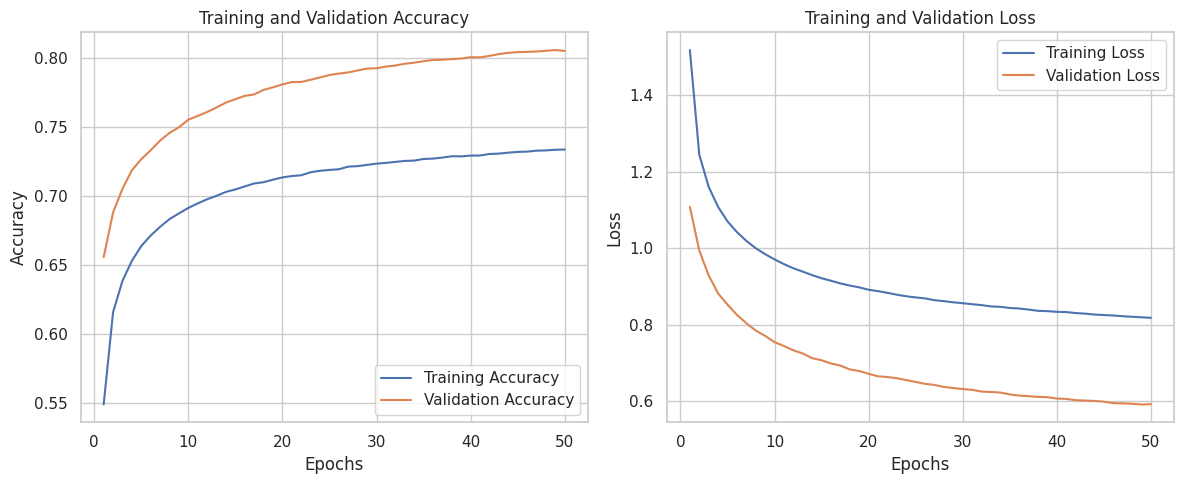

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Plotting the results with Seaborn
epochs = range(1, num_epoch + 1)

sns.set(style='whitegrid')

plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
sns.lineplot(x=epochs, y=train_info["Acc"], label='Training Accuracy')
sns.lineplot(x=epochs, y=val_info["Acc"], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
sns.lineplot(x=epochs, y=train_info["Loss"], label='Training Loss')
sns.lineplot(x=epochs, y=val_info["Loss"], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.savefig("Model_2.png")
plt.show()

In [36]:
torch.save(model.state_dict())

TypeError: save() missing 1 required positional argument: 'f'

In [ ]:
model = RNN(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()

# Compare Result with different Model

**Base**

![image.png](attachment:4373f474-b07f-440e-a058-994c20029480.png)

**Narrow and Depper**

![image.png](attachment:435d6720-2070-4b29-b475-b3e0ed267965.png)

*Notes*
- Starting over fitting after 7tg or 8th epochs.

**wider and shallower**

Typical disadvantage of wide and shallow model:
- Computational Complexity:
    >A wide and shallow network with a vast number of input neurons can result in high computational complexity. Training and making predictions with such networks may be computationally expensive, especially as the number of **parameters increases**.
- Overfitting:
    >Shallow networks may struggle with capturing complex patterns in the data. The model might end up fitting the training data too closely, leading to overfitting. Overfitting occurs when the model performs well on training data but poorly on unseen data.
- Limited Representational Power:
    >Shallow networks might not have enough depth to learn hierarchical representations of features in the data. Deep networks, with multiple hidden layers, are often better suited for **capturing intricate relationships and representations**.
- Feature Extraction Challenges:
    >Wide and shallow networks may face challenges in automatic feature extraction. Deep networks, by design, learn hierarchical features from data, allowing them to automatically **extract and represent meaningful features**.


![image.png](attachment:9ae31e8c-b189-43ba-a3d7-5975f33760c5.png)

*Notes*

- Here, we only see the time of training is longer than deeper model, which we train last.

**Drop out rate 0.25**

![image.png](attachment:90438905-0288-4be4-ae0b-867881d5fe62.png)

*Notes*

- Because the train set and validation set are not that overlap when we trained, it seems not that easy to overfitting.

**Drop out rate 0.5**

![image.png](attachment:7255f60f-393c-4198-b659-0ee5f049a34e.png)

*Notes*

- As we increse the rate, we see it more flater after 20 epochs than 0.25 rate

**Drop out rate 0.75**

![image.png](attachment:30e85442-34c5-4aa9-b00f-fba859cf4dfc.png)

*Notes*

- A big problem is we increse the rate to prevent over fitting, but it will under fitting.

*Insights*

- We can use deeper and narrow model and deop out to train model.

**drop out rate 0.5 and deep + narrow model**

![image.png](attachment:c4387e4f-4531-4d98-aae8-9de0a9372758.png)

*Notes*

- It doesn't overfitting and the accuracy is the highest so far.

**BN -> ReLU -> Dropout**

![image.png](attachment:23920f65-b5b6-4744-9f59-4d0cc2933674.png)

**Linear -> ReLU -> Dropout -> BN -> Linear**

![image.png](attachment:6cfd7444-53aa-4525-ad26-6d4995591b4e.png)

**Concat 5**

![image.png](attachment:3694e598-a193-41f6-ba8a-fd94f7cbe236.png)

**Concat 7**

![image.png](attachment:2801749b-0b7d-4761-91e9-ad3883eac6ba.png)